# Scanpy: Integrating data using ingest and BBKNN

https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html

（更新日:2020-12-28）

以下のチュートリアルでは、[ingest](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) というシンプルなPCAベースのデータ統合手法を説明し、[BBKNN [Polanski19]](https://doi.org/10.1093/bioinformatics/btz625)と比較します。BBKNNはScanpyのワークフローとうまく統合されており、[bbknn関数](https://scanpy.readthedocs.io/en/stable/external/scanpy.external.pp.bbknn.html)を通してアクセスできます。

- ingest関数は、関心のある biological variabilityをキャプチャした annotated reference dataset を想定しています。
- 理論としては、referenceデータにモデルをフィットさせ、新しいデータを投影することです。
- 今のところ、このモデルはPCAと近傍探索木を組み合わせたものであり、そのためにUMAPを使用しています[[McInnes18]](https://arxiv.org/abs/1802.03426)。同様のPCAベースの統合は以前にも、例えば[[Weinreb18]](https://doi.org/10.1101/467886)で使用されています。

- ingestはシンプルで手順が明確なので、ワークフローは透明性が高く高速です。
- BBKNNと同様に、ingestはデータ行列自体を不変にします．
- BBKNNとは異なり、ingestは（scmapのような）ラベルマッピング問題を解決し、特定のクラスタや軌跡のような望ましい特性を持つ可能性のある埋め込みを維持します。

- この を、アノテーションされたデータ `adata_ref` から、アノテーションがまだない `adata` にアノテーションを*ingesting* することをここでは*asymmetric* なデータセット統合と呼ぶ。
- これは、BBKNN, Scanorma, Conos, CCA (例：Seurat)や条件付きVAE (例：scVI, trVAE)のような、symmetricな方法でデータセットを統合する learning a joint representationとは異なりますが、scranの初期のMNN実装とは類似しています。
- [外部APIのツール](https://scanpy.readthedocs.io/en/latest/external/#)を見て、他のツールを使ってみてください。

In [3]:
import scanpy as sc
import pandas as pd
import seaborn as sns

sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.5 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.3


## PBMCs

In [4]:
adata_ref = sc.datasets.pbmc3k_processed()  # this is an earlier version of the dataset from the pbmc3k tutorial
adata = sc.datasets.pbmc68k_reduced()

`sc.tl.ingest`を使用するには、データセットを同じ変数で定義する必要があります。



In [5]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

reference データ上で訓練されたモデルとグラフ（ここではPCA、neighbors、UMAP）は、その中で観察された生物学的変動を説明します。

In [6]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

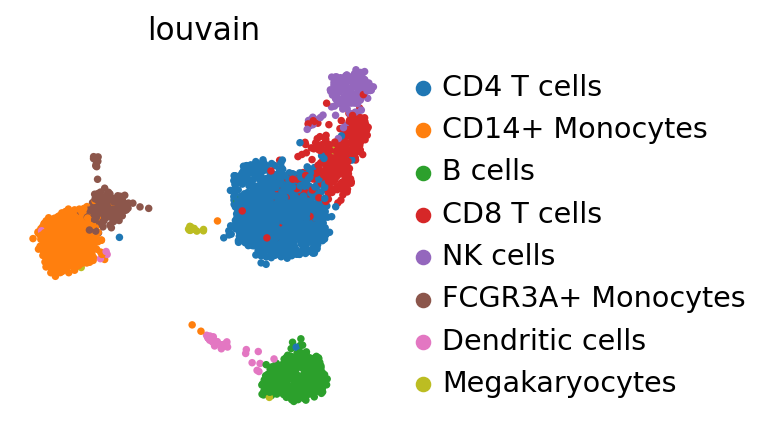

In [7]:
sc.pl.umap(adata_ref, color='louvain')

### Mapping PBMCs using ingest

`adata_ref` から選択した表現に基づいて、ラベルと埋め込みを `adata` にマッピングします。
ここでは、クラスタラベルとUMAP座標をマッピングするために `adata_ref.obsm['X_pca']` を使用します。

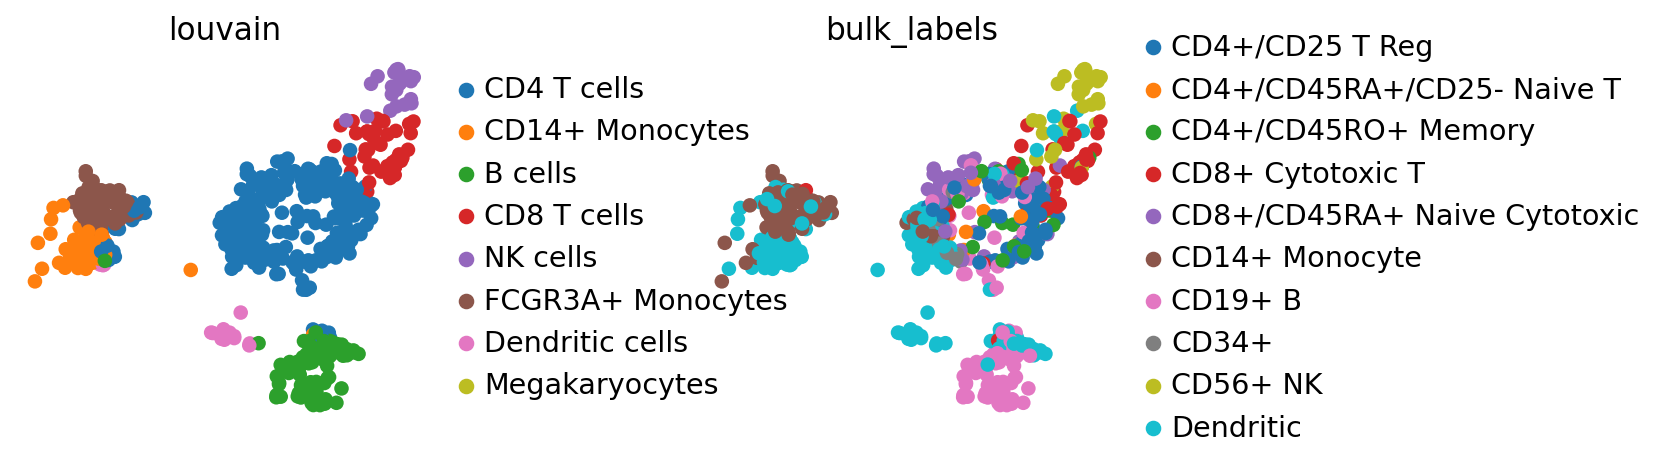

In [8]:
sc.tl.ingest(adata, adata_ref, obs='louvain')
adata.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix colors
sc.pl.umap(adata, color=['louvain', 'bulk_labels'], wspace=0.5)

**bulk_labels** のアノテーションと **louvain** のアノテーションを比較すると、データが合理的にマッピングされていることがわかりますが、樹状細胞 (dendritic cells) のアノテーションだけが曖昧なようです。
adata_ref ではすでに曖昧になっているかもしれません。

... storing 'bulk_labels' as categorical
... storing 'phase' as categorical


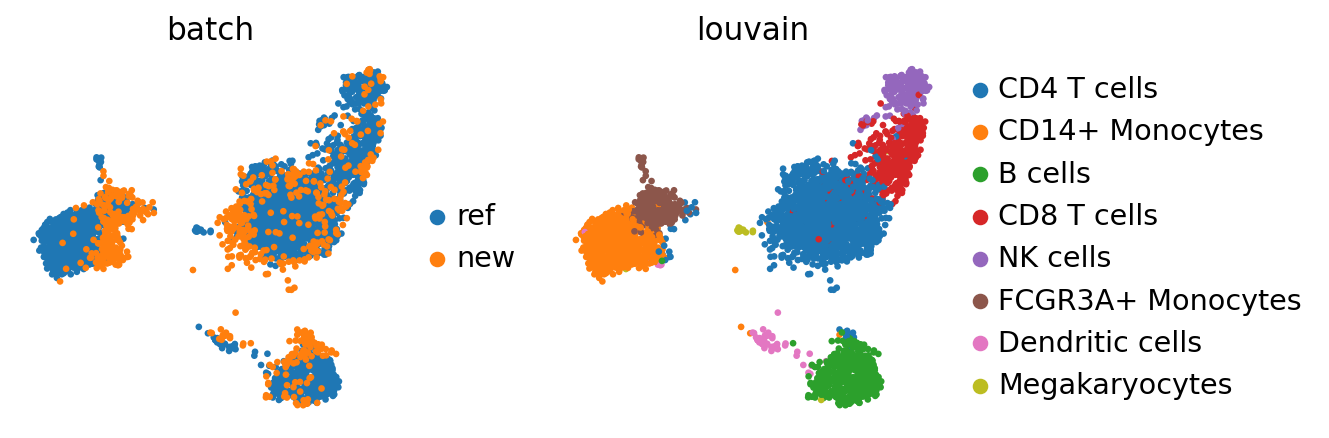

In [9]:
adata_concat = adata_ref.concatenate(adata, batch_categories=['ref', 'new'])
adata_concat.obs.louvain = adata_concat.obs.louvain.astype('category')
adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix category colors
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

- 単球(monocytes)と樹状細胞群 (dendritic cell)にはバッチ効果があるようだが、それ以外の新しいデータは比較的均一にマップされている。
- Megakaryocytes  は`adata_ref`にのみ存在し、`adata`からの細胞はそれらにマッピングされていません。
- 参照データとクエリデータを入れ替えた場合、Megakaryocytes は別個のクラスタとして表示されなくなります。
- これは参照データが非常に小さい極端なケースですが、参照データがクエリデータを意味のある形で適合させるのに十分な生物学的変異を含んでいるかどうかを常に注意する必要があります。

### Using BBKNN

In [10]:
sc.tl.pca(adata_concat)

In [11]:
%%time
sc.external.pp.bbknn(adata_concat, batch_key='batch')  # running bbknn 1.3.6

CPU times: user 11.6 s, sys: 906 ms, total: 12.5 s
Wall time: 353 ms


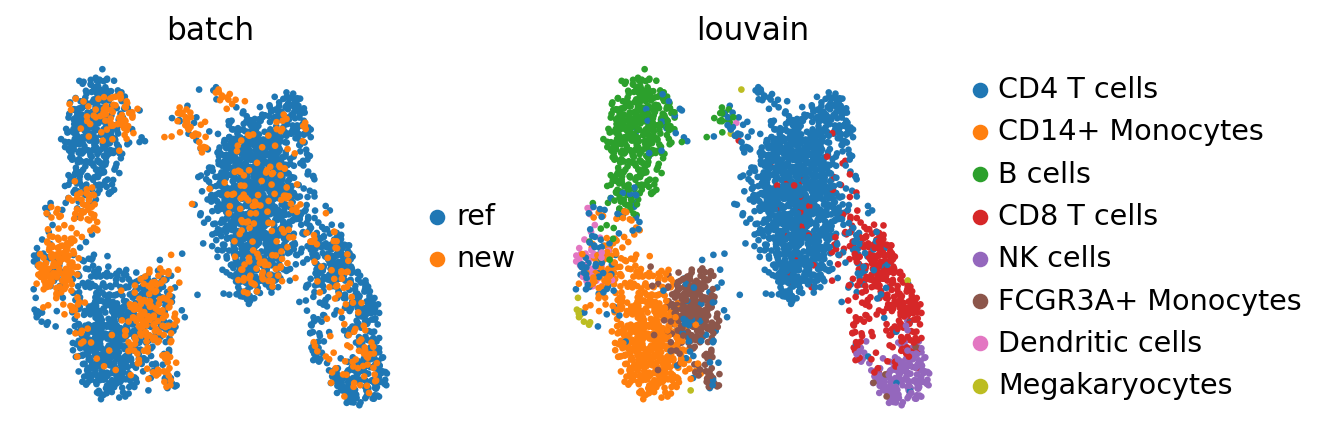

In [12]:
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

BBKNNはMegakaryocytes クラスタを維持していません。しかし、より均一に細胞が混ざり合っているようです。

## Pancreas

- 以下のデータは[scGen論文](https://doi.org/10.1038/s41592-019-0494-8)で使用され、[ここ](ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip)からダウンロードすることができます（BBKNN論文）。
- このデータは、4つの異なる研究からのヒト膵臓のデータを含んでおり、単細胞データセットの統合に関する論文(Butler18, Haghverdi18)やそれ以来何度も使用されています。

In [13]:
# note that this collection of batches is already intersected on the genes
adata_all = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [14]:
adata_all.shape

(14693, 2448)

In [15]:
counts = adata_all.obs.celltype.value_counts()
counts

alpha                     4214
beta                      3354
ductal                    1804
acinar                    1368
not applicable            1154
delta                      917
gamma                      571
endothelial                289
activated_stellate         284
dropped                    178
quiescent_stellate         173
mesenchymal                 80
macrophage                  55
PSC                         54
unclassified endocrine      41
co-expression               39
mast                        32
epsilon                     28
mesenchyme                  27
schwann                     13
t_cell                       7
MHC class II                 5
unclear                      4
unclassified                 2
Name: celltype, dtype: int64

To simplify visualization, let’s remove the 5 minority classes.

In [16]:
minority_classes = counts.index[-5:].tolist()        # get the minority classes
adata_all = adata_all[                               # actually subset
    ~adata_all.obs.celltype.isin(minority_classes)]
adata_all.obs.celltype.cat.reorder_categories(       # reorder according to abundance
    counts.index[:-5].tolist(), inplace=True)

### Seeing the batch effect

In [17]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

We observe a batch effect.

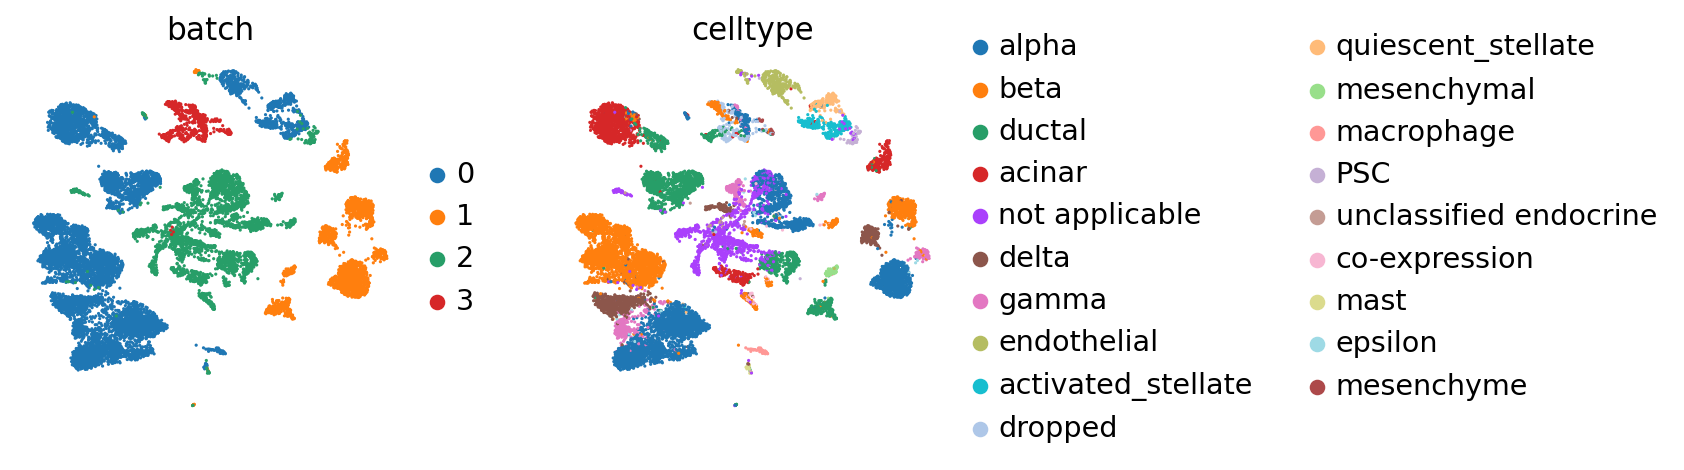

In [18]:
sc.pl.umap(adata_all, color=['batch', 'celltype'], palette=sc.pl.palettes.vega_20_scanpy)

### BBKNN

In [19]:
%%time
sc.external.pp.bbknn(adata_all, batch_key='batch')

CPU times: user 1.8 s, sys: 21 ms, total: 1.82 s
Wall time: 1.63 s


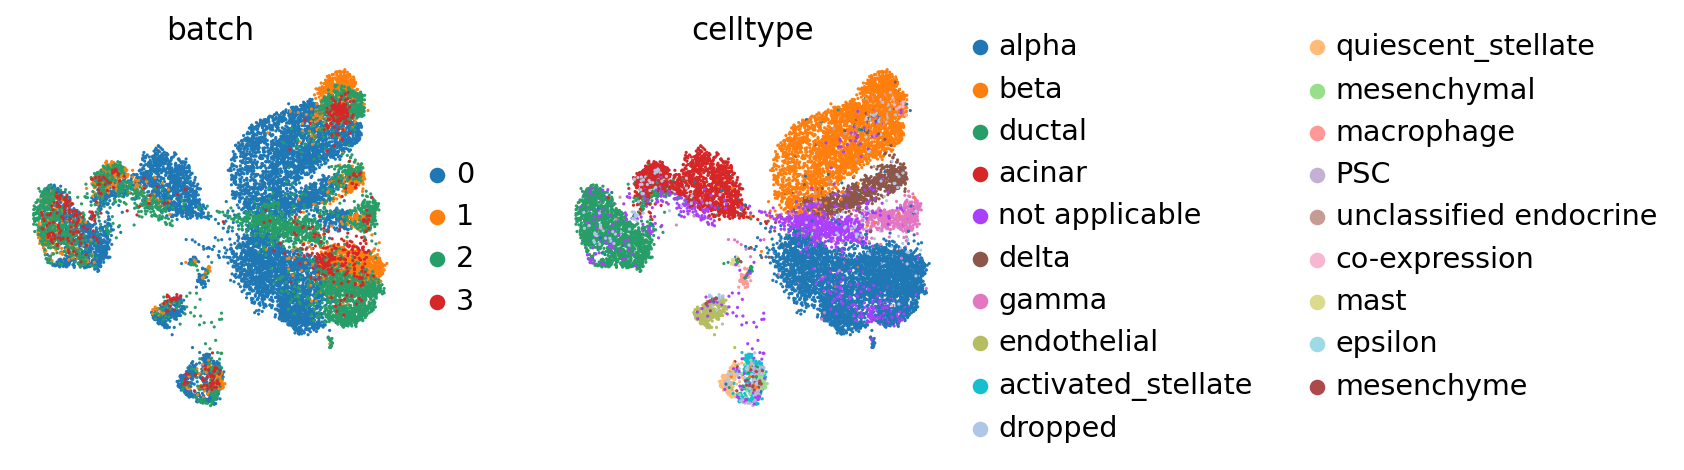

In [20]:
sc.tl.umap(adata_all)
sc.pl.umap(adata_all, color=['batch', 'celltype'])

1つのリファレンスデータセットから反復的に作業したい場合は、ingestを使用することができます。



## Mapping onto a reference batch using ingest

モデルを訓練し、近傍グラフを設定するために1つの参照バッチを選択し（ここでは、PCA）、他のすべてのバッチを分離します。

前述のように、参照バッチで訓練されたモデルは、その中で観察された生物学的変動を説明します。

In [21]:
adata_ref = adata_all[adata_all.obs.batch == '0']

In [22]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

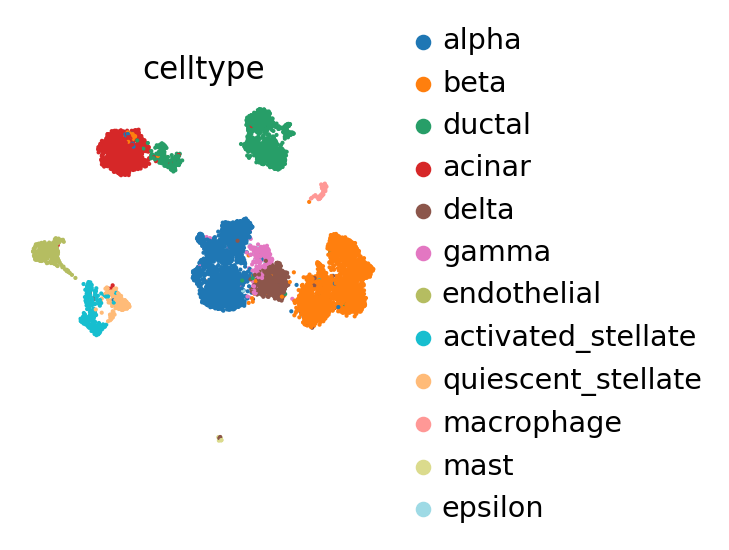

In [23]:
sc.pl.umap(adata_ref, color='celltype')

ラベル（'celltype'など）とembedding（'X_pca'や'X_umap'など）を参照データからクエリバッチに反復的にマッピングする。

In [24]:
adatas = [adata_all[adata_all.obs.batch == i].copy() for i in ['1', '2', '3']]

In [25]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f'... integrating batch {iadata+1}')
    adata.obs['celltype_orig'] = adata.obs.celltype  # save the original cell type
    sc.tl.ingest(adata, adata_ref, obs='celltype')

... integrating batch 1
running ingest
    finished (0:00:06)
... integrating batch 2
running ingest
    finished (0:00:06)
... integrating batch 3
running ingest
    finished (0:00:03)


クエリの各バッチは、`adata_ref`でコンテキスト化されたアノテーションを運ぶようになりました。連結することで、それを一緒に表示することができます。

In [26]:
adata_concat = adata_ref.concatenate(adatas)

In [27]:
adata_concat.obs.celltype = adata_concat.obs.celltype.astype('category')
adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['celltype_colors'] = adata_ref.uns['celltype_colors']  # fix category coloring

... storing 'sample' as categorical
... storing 'louvain' as categorical
... storing 'celltype_orig' as categorical


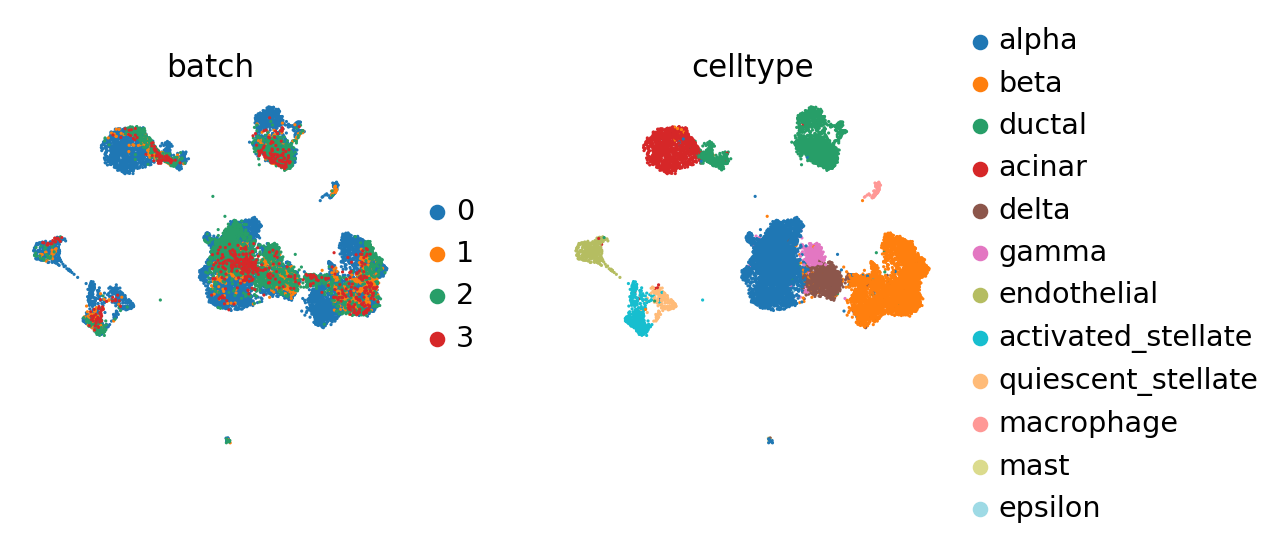

In [28]:
sc.pl.umap(adata_concat, color=['batch', 'celltype'])

BBKNNの結果と比較して、より顕著な方法でクラスターが維持されています。
もし、（例えば、造血幹細胞データセットのように）望まれる連続構造がすでに観測されている場合、ingest はこの構造を簡単に維持することができます。

### Evaluating consistency

データをクエリバッチにサブセットします。

In [29]:
adata_query = adata_concat[adata_concat.obs.batch.isin(['1', '2', '3'])]

Trying to set attribute `.uns` of view, copying.


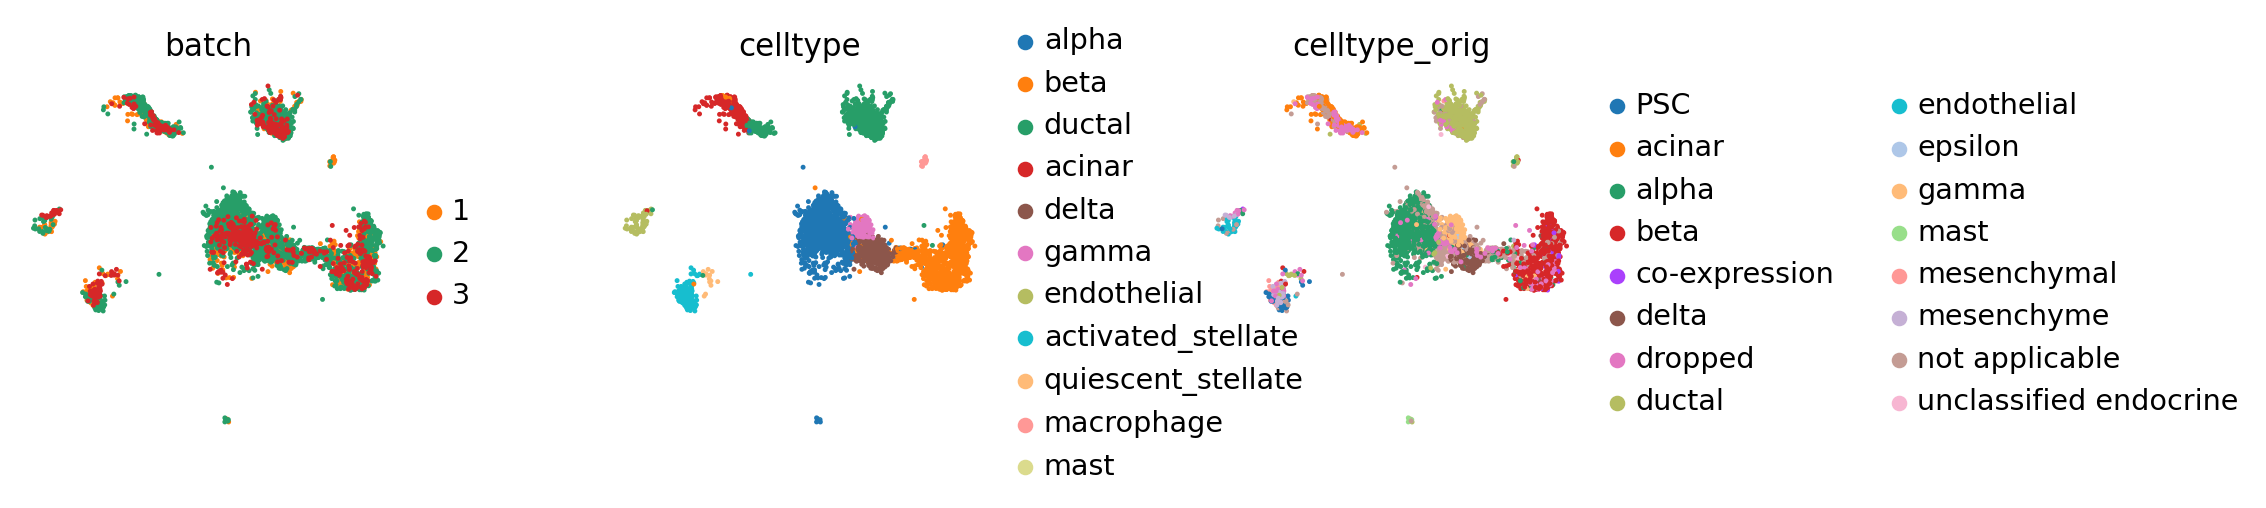

In [30]:
sc.pl.umap(adata_query, color=['batch', 'celltype', 'celltype_orig'], wspace=0.4)

### Cell types conserved across batches

まず、confusion matrixからの読み取りを簡単にするために、リファレンスで保存されている細胞型に焦点を当ててみましょう。



In [31]:
obs_query = adata_query.obs
conserved_categories = obs_query.celltype.cat.categories.intersection(obs_query.celltype_orig.cat.categories)  # intersected categories
obs_query_conserved = obs_query.loc[obs_query.celltype.isin(conserved_categories) & obs_query.celltype_orig.isin(conserved_categories)]  # intersect categories
obs_query_conserved.celltype.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.reorder_categories(obs_query_conserved.celltype.cat.categories, inplace=True)  # fix category ordering

In [32]:
pd.crosstab(obs_query_conserved.celltype, obs_query_conserved.celltype_orig)

celltype_orig,alpha,beta,ductal,acinar,delta,gamma,endothelial,mast
celltype,,,,,,,,
alpha,1819,3,6,0,1,24,0,6
beta,49,804,4,1,10,22,0,0
ductal,7,5,692,240,0,0,0,0
acinar,2,3,3,168,0,3,0,0
delta,5,4,0,0,305,73,0,0
gamma,1,5,0,0,0,194,0,0
endothelial,2,0,0,0,0,0,36,0
mast,0,0,1,0,0,0,0,1


全体的に、保存されている細胞タイプも予想通りにマップされています。主な例外は、元のアノテーションでは、いくつかのアキナール (acinar)細胞がアキナール細胞として表示されていることです。
かし、すでに参照データにおいて、アキナール細胞と管腔細胞の両方のクラスターが観察されており、初期のアノテーションに矛盾がある可能性を示唆しています。

### All cell types

次は全細胞型です。

In [39]:
pd.crosstab(adata_query.obs.celltype, adata_query.obs.celltype_orig)

celltype_orig,PSC,acinar,alpha,beta,co-expression,delta,dropped,ductal,endothelial,epsilon,gamma,mast,mesenchymal,mesenchyme,not applicable,unclassified endocrine
celltype,,,,,,,,,,,,,,,,
alpha,0,0,1819,3,2,1,35,6,0,4,24,6,0,0,310,10
beta,0,1,49,804,35,10,40,4,0,0,22,0,0,1,512,24
ductal,0,240,7,5,0,0,41,692,0,0,0,0,1,0,102,1
acinar,0,168,2,3,0,0,25,3,0,0,3,0,0,0,89,0
delta,0,0,5,4,1,305,13,0,0,4,73,0,0,0,101,6
gamma,0,0,1,5,0,0,1,0,0,2,194,0,0,0,14,0
endothelial,1,0,2,0,1,0,7,0,36,0,0,0,0,6,7,0
activated_stellate,49,1,1,3,0,0,11,8,0,0,0,0,79,20,17,0
quiescent_stellate,4,0,1,1,0,0,5,1,1,0,0,0,0,0,1,0


ここではPSC（[pancreatic stellate cells](https://en.wikipedia.org/wiki/Pancreatic_stellate_cell)）細胞が実際には矛盾してアノテーションおり、正しくは"activated_stellate"細胞にマッピングされています。

また、'mesenchyme'細胞と'mesenchymal'細胞が同じカテゴリーにマップされているのは嬉しいことです。しかし、そのカテゴリーは再び"activated_stellate"となっており、おそらく間違っているだろう。

### Visualizing distributions across batches

Scanpyはバッチ（実験）間で比較する便利な可視化機能を提供します。

In [34]:
sc.tl.embedding_density(adata_concat, groupby='batch')

computing density on 'umap'


/opt/conda/lib/python3.7/site-packages/scanpy/plotting/_tools/__init__.py:1156: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_over('black')
/opt/conda/lib/python3.7/site-packages/scanpy/plotting/_tools/__init__.py:1157: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_under('lightgray')
/opt/conda/lib/python3.7/site-packages/scanpy/plotting/_tools/scatterplots.py:400: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will be

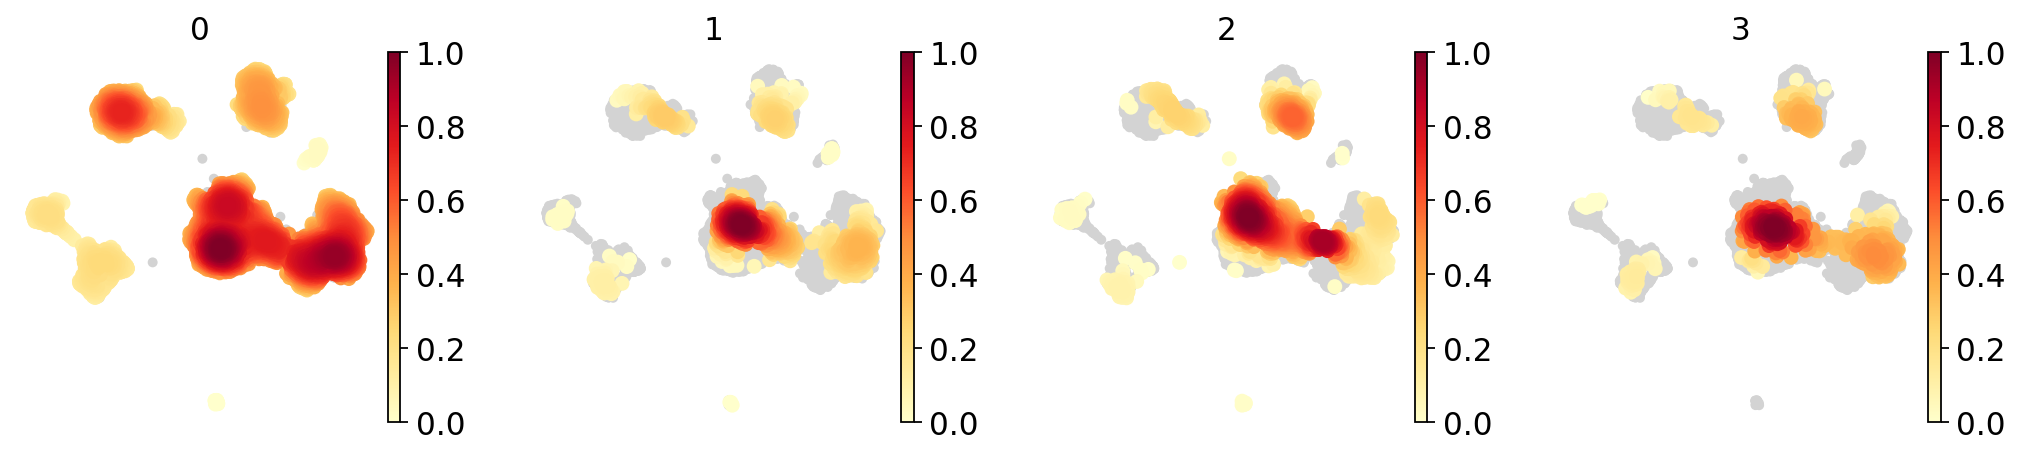

In [35]:
sc.pl.embedding_density(adata_concat, groupby='batch')

### Partial visualizaton of a subset of groups in embedding


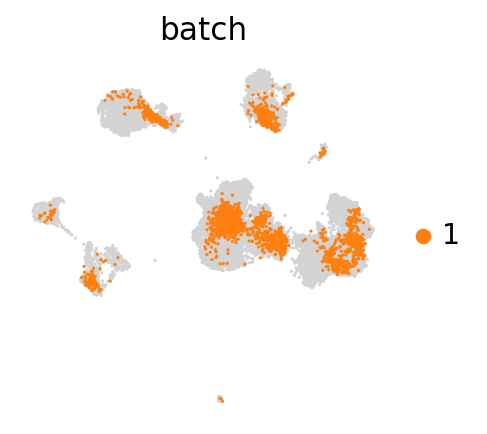

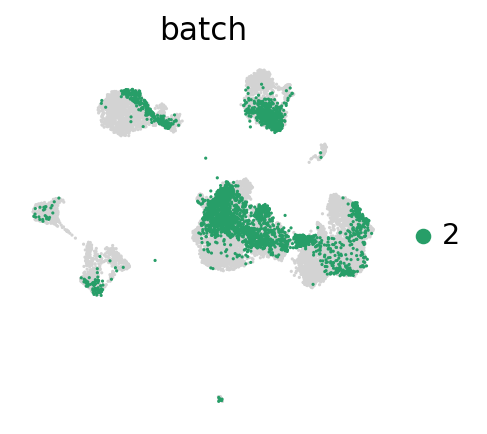

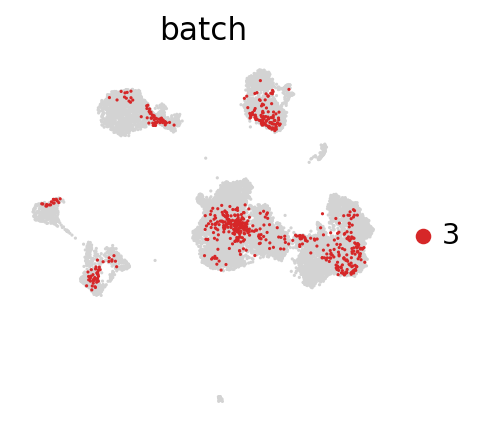

In [36]:
for batch in ['1', '2', '3']:
    sc.pl.umap(adata_concat, color='batch', groups=[batch])

In [37]:
from sinfo import sinfo
sinfo()

-----
anndata     0.7.5
pandas      1.1.5
scanpy      1.6.0
seaborn     0.11.0
sinfo       0.3.1
-----
IPython             7.13.0
jupyter_client      6.1.7
jupyter_core        4.7.0
jupyterlab          2.2.9
notebook            6.1.5
-----
Python 3.7.7 (default, Mar 23 2020, 22:36:06) [GCC 7.3.0]
Linux-5.4.0-47-generic-x86_64-with-debian-buster-sid
72 logical CPU cores, x86_64
-----
Session information updated at 2020-12-29 18:38
